### Cab-Driver Agent

Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Basic environment parameters

In [3]:
# Defining hyperparameters
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
C = 5 # Per kilometer fuel and other costs
R = 9 # per kilometer revenue from a passenger

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking Q-value convergence

In [5]:
states_track = collections.defaultdict(dict)
def initialise_tracking_states():
    sample_q_values = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2)),((3,10,6),(3,4)),((0,20,3),(1,4)), ((1,23,3),(1,4))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        states_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

In [6]:
initialise_tracking_states() # initialised all the state-action pairs tracked

In [7]:
# This function will append latest Q-values of the 6 Q-values which are being tracked for checking convergence

def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            state_encod = env.state_encod_arch1(state)
            state_encod = np.reshape(state_encod, [1, agent.state_size])
            prediction = agent.model.predict(state_encod)
            action_list = list(action)
            #print("Action", action_list)
            action_index = env.action_space.index(action_list)
            #print("Action index", action_index)
            Q = prediction[0][action_index]
            #print("Q", Q)
            states_track[state][action].append(Q)          

In [8]:
#Defining a function to save the object as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

## Building Agent Class

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):

        # Define size of state and action
        self.state_size = m+t+d 
        self.action_size = m*(m-1) + 1
        self.action_space = [[i,j] for i in range(m) for j in range(m) if i!=j or i==0]

        # These are hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001        
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

        

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(200, input_dim = self.state_size,activation ='relu'))
        model.add(Dense(150,activation ='relu'))
        model.add(Dense(100,activation ='relu'))
        model.add(Dense(self.action_size,activation ='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, episode):
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
        poss_actions_index, poss_actions = env.requests(state)
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
        
    
        if np.random.rand() <= epsilon: # Exploration: randomly choosing and action      
            action_index = np.random.choice(poss_actions_index)
            action = self.action_space[action_index]
        else: #Exploitation: this gets the action corresponding to max q-value of current state
            state_encod = env.state_encod_arch1(state)
            state_encod = np.reshape(state_encod, [1, self.state_size])
            q_value = self.model.predict(state_encod)
            q_value = q_value[0][poss_actions_index]
            action_index = np.argmax(q_value)
            action = poss_actions[action_index]
            
        return action, epsilon
        
        
    # save sample <s,a,r,s'> to the replay memory 
    def append_sample(self, state, action, reward, next_state, terminal_state):
        self.memory.append((state, action, reward, next_state, terminal_state))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
  

        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        update_output = np.zeros((self.batch_size, self.state_size))
        update_input = np.zeros((self.batch_size, self.state_size))

        actions, rewards, terminal_states = [], [], []

        
        
        for i in range(self.batch_size):
            
            state, action, reward, next_state, terminal_state = mini_batch[i]
            
            actions.append(self.action_space.index(action))
            rewards.append(reward)
            terminal_states.append(terminal_state)
            

            update_input[i] = env.state_encod_arch1(state)
            update_output[i] = env.state_encod_arch1(next_state)
                
        target = self.model.predict(update_input)
        target_val = self.model.predict(update_output)
        
        # get your target Q-value on the basis of terminal state
        for i in range(self.batch_size):
            if terminal_states[i]:
                #print(True)
                target[i][actions[i]] = rewards[i]
                
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

                
                
    def load(self, name):
        self.model.load_weights(name)
        
                    
    def save(self, name):
        self.model.save_weights(name)

### DQN block

In [10]:
# Importing the environment
from Env import CabDriver

In [11]:
# Initialising the environment
env = CabDriver()
# get size of state and action from environment
state_size = len(env.state_space)
action_size = len(env.action_space)

# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(state_size, action_size)

# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []

# tracking total rewards per episode
total_reward  = []

In [13]:
Episodes = 40000
for episode in range(0,Episodes):
    
    # tracking total rewards, step count
    tot_reward = 0
    step_count = 0
    state = env.reset()
    terminal_state = False
    
    while not terminal_state:
        

        action, epsilon = agent.get_action(state, episode)
        reward = env.reward_func(state, action, Time_matrix)
        
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # every time step do the training
        agent.train_model()
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards
        if terminal_state and episode % 25 ==0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode, "  score:", tot_reward, "  memory length:",
                      len(agent.memory), "  epsilon:", epsilon)
    
    if episode % 200 == 0:
            agent.save("./cab_driver.h5")

    if episode % 25 == 0:   #every 2000th episode
        save_obj(avg_reward,'Rewards')   
        save_tracking_states()
        save_obj(states_track,'States_tracked')   
        
    
    if episode % 10000 ==0 and episode !=0:
        plt.plot(list(range(len(avg_reward))), avg_reward)
        plt.show()
        

        

AttributeError: 'CabDriver' object has no attribute 'state_trans'

### Plotting results

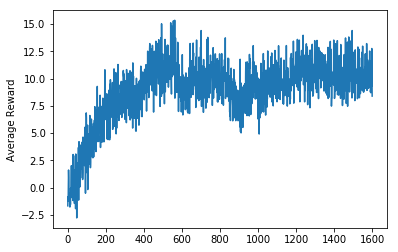

In [82]:
# Plotting average rewards
# x-values = 40000 episodes tracked after every 25th episode
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.ylabel("Average Reward")
plt.show()

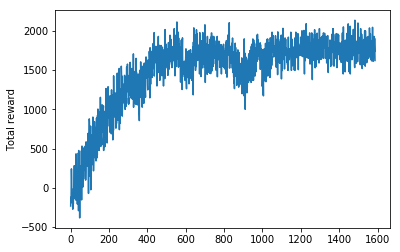

In [85]:
# Plotting total rewards
plt.plot(list(range(len(total_reward))), total_reward)
plt.ylabel("Total reward")
plt.show()

### Intuition behind  total expected reward in an episode

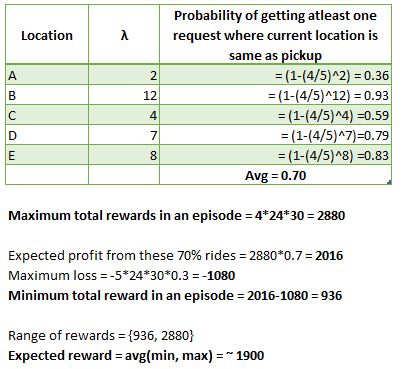 

## Checking Q-values

<function matplotlib.pyplot.show(*args, **kw)>

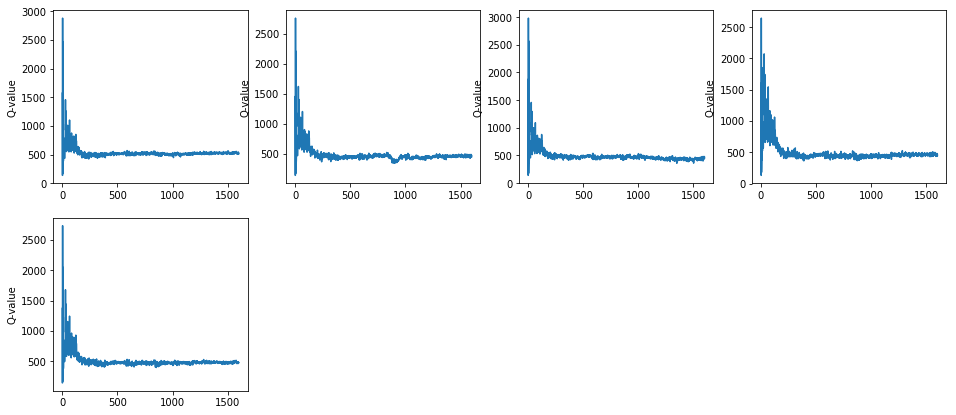

In [86]:
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(len(states_track[(3,0,2)][(3,1)])))
plt.subplot(241)
plt.plot(xaxis,np.asarray(states_track[(3,0,2)][(3,1)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(1,6,3)][(2,3)])))
plt.subplot(242)
plt.plot(xaxis,np.asarray(states_track[(1,6,3)][(2,3)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(2,2,2)][(3,2)])))
plt.subplot(243)
plt.plot(xaxis,np.asarray(states_track[(2,2,2)][(3,2)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(3,10,6)][(3,4)])))
plt.subplot(244)
plt.plot(xaxis,np.asarray(states_track[(3,10,6)][(3,4)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(0,20,3)][(1,4)])))
plt.subplot(245)
plt.plot(xaxis,np.asarray(states_track[(0,20,3)][(1,4)]))
plt.ylabel("Q-value")
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

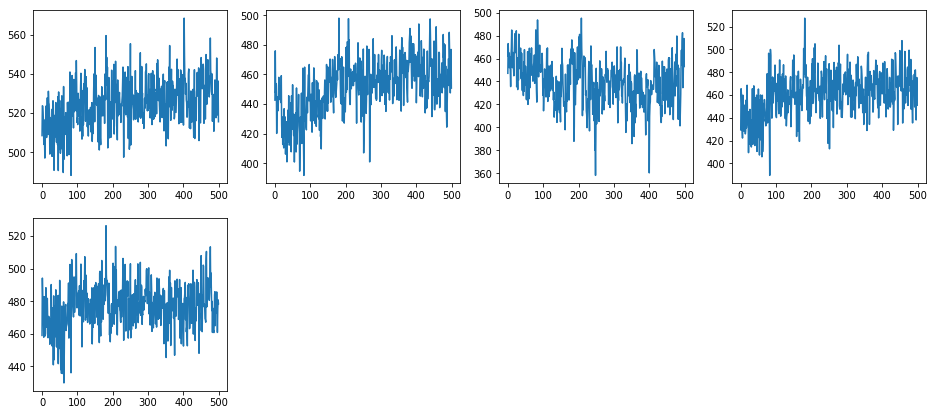

In [70]:
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(500))
plt.subplot(241)
plt.plot(xaxis,np.asarray(states_track[(3,0,2)][(3,1)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(242)
plt.plot(xaxis,np.asarray(states_track[(1,6,3)][(2,3)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(243)
plt.plot(xaxis,np.asarray(states_track[(2,2,2)][(3,2)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(244)
plt.plot(xaxis,np.asarray(states_track[(3,10,6)][(3,4)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(245)
plt.plot(xaxis,np.asarray(states_track[(0,20,3)][(1,4)])[-500:])
plt.ylabel("Q-value")
plt.show

#### Interpreting Q-values

In [73]:
# (3,0,2), # (0, 10, 5)

state_encod = env.state_encod_arch1([3,0,2])
state_encod = np.reshape(state_encod, [1, agent.state_size])
prediction = agent.model.predict(state_encod)

In [76]:
actions = env.action_space

In [79]:
dict = {}
for i,j in enumerate(actions):
    dict[tuple(j)]=prediction[0][i]
    
print(dict)
print(max(dict,key=dict.get))

{(0, 0): 499.2287, (0, 1): 458.3159, (0, 2): 443.60864, (0, 3): 409.20212, (0, 4): 437.63565, (1, 0): 413.1181, (1, 2): 411.98727, (1, 3): 435.82574, (1, 4): 424.3457, (2, 0): 463.49304, (2, 1): 391.45883, (2, 3): 456.28223, (2, 4): 449.969, (3, 0): 532.9902, (3, 1): 519.361, (3, 2): 510.39117, (3, 4): 488.54572, (4, 0): 380.10046, (4, 1): 387.48196, (4, 2): 340.34442, (4, 3): 360.05545}
(3, 0)


In [81]:
Time_matrix[3]

array([[[10.,  6.,  8.,  5.,  7.,  4.,  6.],
        [10.,  6.,  8.,  5.,  7.,  4.,  6.],
        [10.,  6.,  8.,  5.,  7.,  4.,  6.],
        [10.,  6.,  8.,  5.,  7.,  4.,  6.],
        [10.,  6.,  8.,  5.,  7.,  4.,  6.],
        [10.,  6.,  8.,  5.,  7.,  4.,  6.],
        [ 3.,  3.,  8.,  6.,  1.,  6.,  3.],
        [ 3.,  3.,  8.,  6.,  1.,  6.,  3.],
        [ 3.,  3.,  8.,  6.,  1.,  6.,  3.],
        [ 3.,  3.,  8.,  6.,  1.,  6.,  3.],
        [ 3.,  3.,  8.,  6.,  1.,  6.,  3.],
        [ 3.,  3.,  8.,  6.,  1.,  6.,  3.],
        [ 2.,  1.,  2.,  5.,  3.,  4.,  0.],
        [ 2.,  1.,  2.,  5.,  3.,  4.,  0.],
        [ 2.,  1.,  2.,  5.,  3.,  4.,  0.],
        [ 2.,  1.,  2.,  5.,  3.,  4.,  0.],
        [ 2.,  1.,  2.,  5.,  3.,  4.,  0.],
        [ 2.,  1.,  2.,  5.,  3.,  4.,  0.],
        [ 0.,  1.,  2.,  3.,  1.,  3.,  3.],
        [ 0.,  1.,  2.,  3.,  1.,  3.,  3.],
        [ 0.,  1.,  2.,  3.,  1.,  3.,  3.],
        [ 0.,  1.,  2.,  3.,  1.,  3.,  3.],
        [ 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(episodes_, scores_, 'b')

#### Epsilon-decay sample function

In [83]:
time = np.arange(0,50000)
epsilon = []
for i in range(0,50000):
    epsilon.append(.00000001 + (1 - 0.00000001) * np.exp(-0.0003*i))

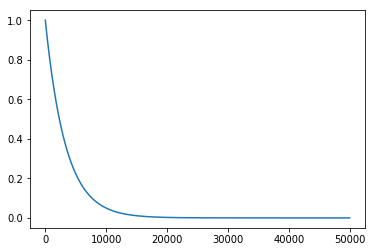

In [84]:
plt.plot(time, epsilon)
plt.show()